In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from urllib.parse import urlparse

In [2]:
matplotlib.rcParams['font.family'] = 'Noto Serif CJK JP'
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('performance_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,url,screenshotpath,run
0,565 ms,2612 ms,13424 ms,0.232,12 ms,3953,5 KB,1411 ms,337,15441 ms,首页,https://172.17.120.201:30443/llm/llmops/projec...,172_17_120_201_30443__market_overview_run1_23-...,7
1,863 ms,2716 ms,16718 ms,0.171,11 ms,3923,3 KB,1571 ms,365,17888 ms,模型,https://172.17.120.201:30443/llm/llmops/projec...,172_17_120_201_30443__market_mw_asset_run1_23-...,7
2,134 ms,1278 ms,6665 ms,0.107,19 ms,3049,3 KB,396 ms,120,7910 ms,应用,https://172.17.120.201:30443/llm/llmops/projec...,172_17_120_201_30443__market_applet_run1_23-02...,7
3,0 ms,798 ms,2722 ms,0.035,23 ms,798,0 KB,8 ms,16,2722 ms,知识,https://172.17.120.201:30443/llm/llmops/projec...,172_17_120_201_30443__market_sample_knowledge_...,7
4,0 ms,801 ms,2723 ms,0.030,25 ms,801,0 KB,8 ms,16,2723 ms,管理中心-用户,https://172.17.120.201:30443/llm/llmops/projec...,172_17_120_201_30443__manage_center_users_run1...,7


In [4]:
t_df = df.drop(['screenshotpath', 'run', 'url'], axis=1)
# t_df = df.columns.difference(['screenshotpath', 'url', 'run'])
t_df['host'] = df['url'].apply(lambda x: urlparse(x).netloc)
t_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,host
0,565 ms,2612 ms,13424 ms,0.232,12 ms,3953,5 KB,1411 ms,337,15441 ms,首页,172.17.120.201:30443
1,863 ms,2716 ms,16718 ms,0.171,11 ms,3923,3 KB,1571 ms,365,17888 ms,模型,172.17.120.201:30443
2,134 ms,1278 ms,6665 ms,0.107,19 ms,3049,3 KB,396 ms,120,7910 ms,应用,172.17.120.201:30443
3,0 ms,798 ms,2722 ms,0.035,23 ms,798,0 KB,8 ms,16,2722 ms,知识,172.17.120.201:30443
4,0 ms,801 ms,2723 ms,0.030,25 ms,801,0 KB,8 ms,16,2723 ms,管理中心-用户,172.17.120.201:30443


In [5]:
def clean_numeric(column):
    if column.dtype == 'object':
        return pd.to_numeric(column.str.replace(r'[^\d.]+', '', regex=True))
    else:
        return column

n_df = t_df.iloc[:, :10].apply(clean_numeric)
n_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive
0,565,2612,13424,0.232,12,3953,5,1411,337,15441
1,863,2716,16718,0.171,11,3923,3,1571,365,17888
2,134,1278,6665,0.107,19,3049,3,396,120,7910
3,0,798,2722,0.035,23,798,0,8,16,2722
4,0,801,2723,0.030,25,801,0,8,16,2723


### 归一化

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
s_df = pd.DataFrame(
    scaler.fit_transform(n_df),
    columns=t_df.columns[0:10]
)
s_df['pagename'] = t_df['pagename']
s_df['host'] = t_df['host']
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
0,0.670717,0.797692,0.895920,0.339492,0.545455,0.628047,1.0,0.436602,0.591304,0.027108,main_page,llmops.transwarp.io
1,0.759417,0.992308,0.679629,0.956120,0.727273,0.499196,1.0,0.612742,0.917391,0.108434,model_management,llmops.transwarp.io
2,0.867558,1.000000,0.672342,0.743649,0.500000,0.688856,1.0,0.618364,1.000000,0.696386,app_management,llmops.transwarp.io
3,0.640340,0.837692,0.680472,0.247113,0.454545,0.484731,1.0,0.565896,0.739130,0.077711,corpus_text_dataset,llmops.transwarp.io
4,0.733900,0.887692,0.677865,0.184758,1.000000,0.563354,1.0,0.609619,0.760870,0.578916,knowledge_management,llmops.transwarp.io


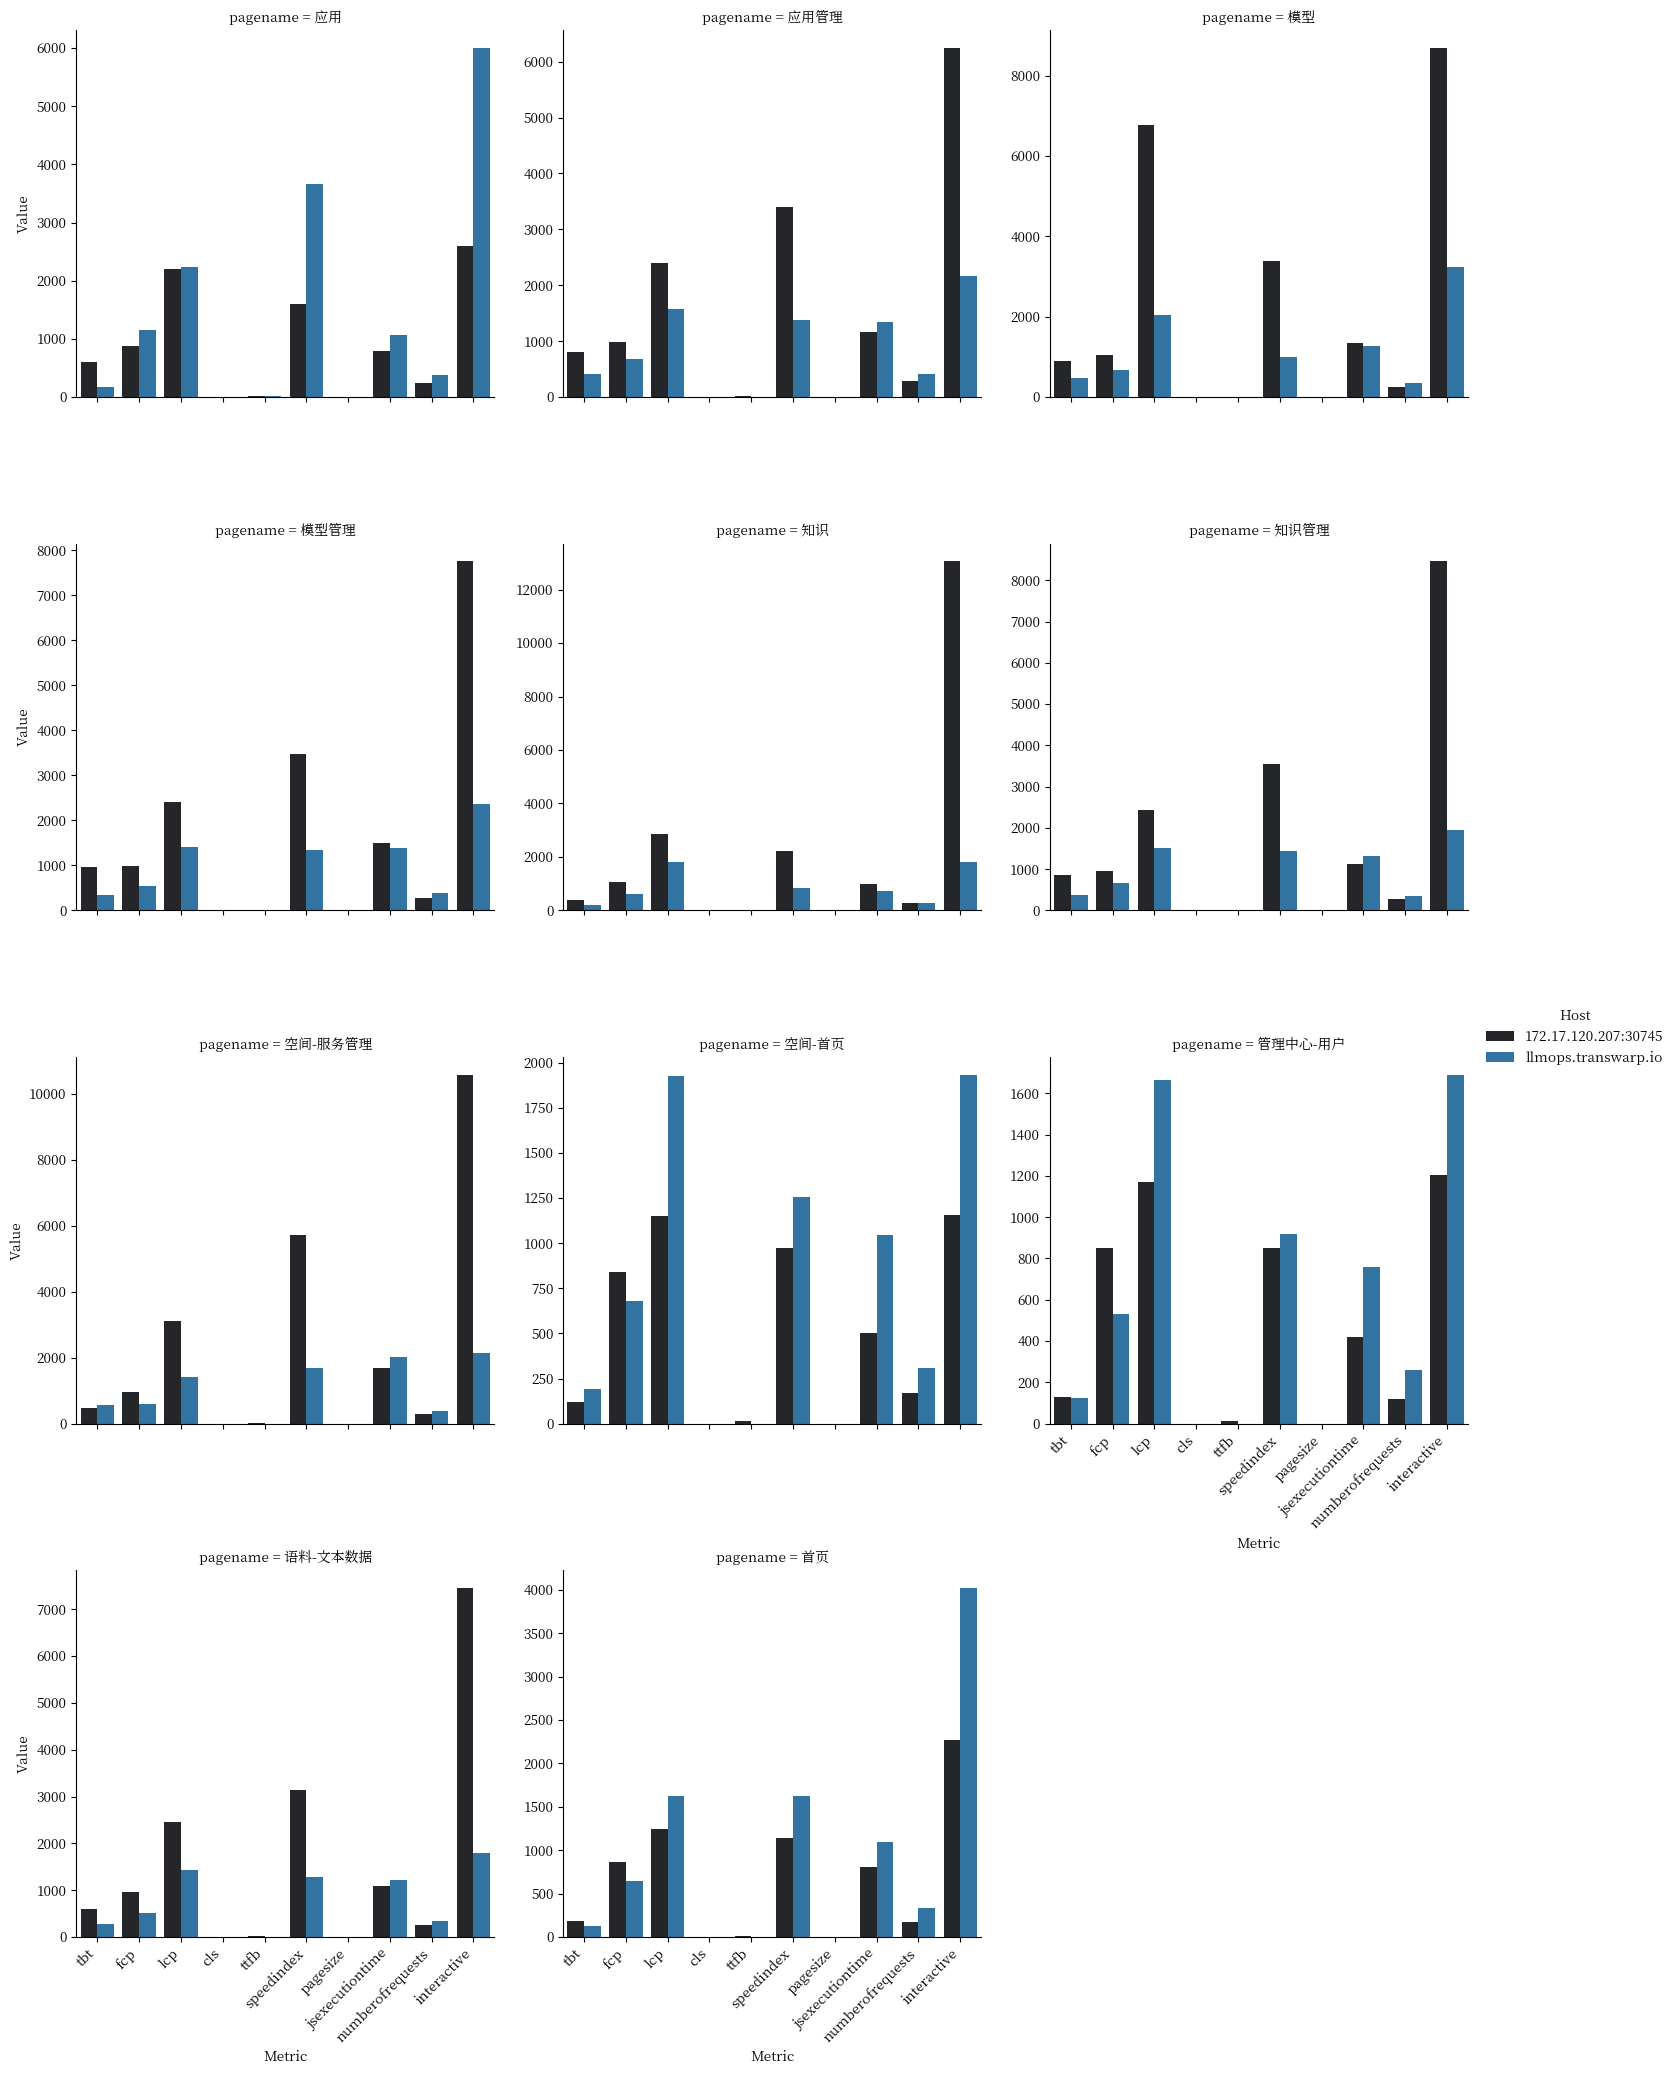

In [43]:
m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')
metric_order = m_df['Metric'].unique()
host_order = m_df['host'].unique()

g = sns.FacetGrid(m_df, col='pagename', col_wrap=3, sharey=False, height=5)
g.map(sns.barplot, 'Metric', 'Value', 'host', dodge=True, palette='dark:#1f77b4', order=metric_order, hue_order=host_order)

# 手动为每个子图设置 x 轴标签，只对最后三个有效, why?
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.add_legend(title='Host')
plt.subplots_adjust(hspace=0.4)
plt.savefig('normalization.png', dpi=300, bbox_inches='tight')
plt.show()

### 百分比

In [71]:
s_df = pd.DataFrame(n_df, columns=t_df.columns[0:10])
s_df['pagename']= t_df['pagename']
s_df['host']= t_df['host']
s_df = s_df.sort_values(['pagename', 'host'])
s_df.head()


,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
9,503,1384,4102,0.255,14,5038,2,1237,296,1696,app_management,172.17.120.207:30745
2,771,2675,12853,0.322,20,7568,3,1596,406,1724,app_management,llmops.transwarp.io
10,312,1382,4096,0.000,9,4203,3,1177,267,875,corpus_text_dataset,172.17.120.207:30745
3,584,2464,12959,0.107,19,6044,3,1512,346,697,corpus_text_dataset,llmops.transwarp.io
11,493,1384,4087,0.000,11,4312,3,1223,272,1542,knowledge_management,172.17.120.207:30745


/tmp/ipykernel_3079/2057756127.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))


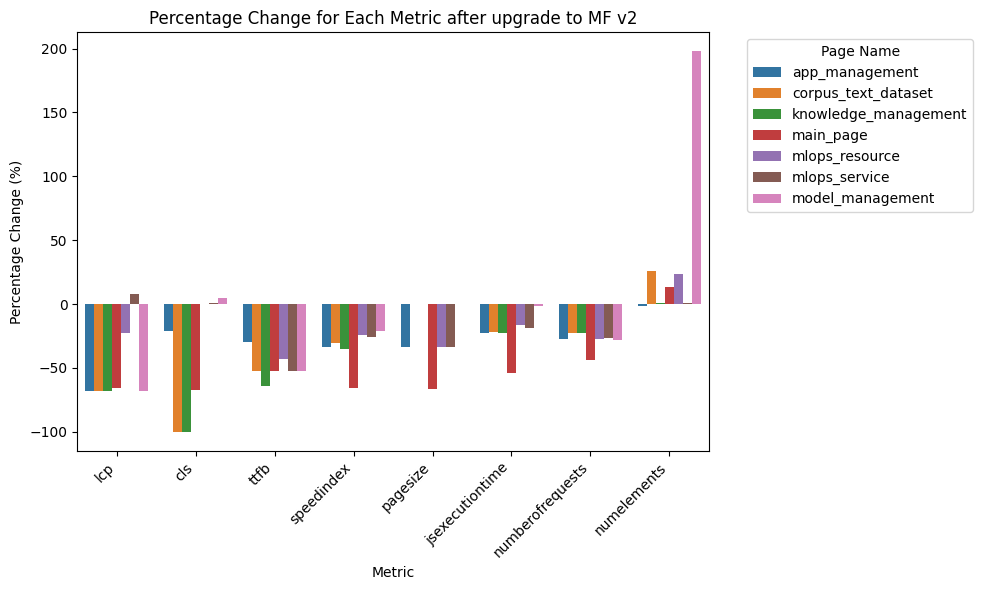

In [75]:
def percentage_change(df):
    row1, row2 = df.iloc[0], df.iloc[1]
    change = (row1 - row2) / row2.replace(0, 1) * 100
    return pd.Series(change, index=df.columns[2:])

g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))

m_df = g_df.reset_index().melt(id_vars='pagename', var_name='Metric', value_name='PercentageChange')
plt.figure(figsize=(10, 6))
sns.barplot(data=m_df, x='Metric', y='PercentageChange', hue='pagename')

plt.title('Percentage Change for Each Metric after upgrade to MF v2')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')

plt.legend(title='Page Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('percentage_change_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 指标维度

In [6]:
s_df = pd.DataFrame(n_df, columns=t_df.columns[0:10])
s_df['pagename']= t_df['pagename']
s_df['host']= t_df['host']
s_df = s_df.sort_values('pagename')
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,host
2,134,1278,6665,0.107,19,3049,3,396,120,7910,应用,172.17.120.201:30443
11,585,1382,11288,0.118,10,4248,2,1278,243,11365,应用,172.17.120.207:30745
7,0,797,2721,0.035,24,797,0,8,16,2721,应用体验,172.17.120.201:30443
16,624,1382,5480,0.000,14,4411,2,1322,270,11400,应用体验,172.17.120.207:30745
1,863,2716,16718,0.171,11,3923,3,1571,365,17888,模型,172.17.120.201:30443


In [7]:
m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')
m_df.head()

,pagename,host,Metric,Value
0,应用,172.17.120.201:30443,tbt,134.0
1,应用,172.17.120.207:30745,tbt,585.0
2,应用体验,172.17.120.201:30443,tbt,0.0
3,应用体验,172.17.120.207:30745,tbt,624.0
4,模型,172.17.120.201:30443,tbt,863.0


In [8]:
c_palette = {
    '172.17.120.201:30443': '#1f77b4',
    '172.17.120.207:30745': '#6a0dad',
}

metric_chinese_mapping = {
    'tbt': 'Total Blocking Time',
    'fcp': 'First Contentful Paint',
    'lcp': 'Largest Contentful Paint',
    'cls': 'Cumulative Layout Shift',
    'ttfb': 'Time to First Byte',
    'speedindex': 'Speed Index',
    'pagesize': 'Page Size',
    'jsexecutiontime': 'JS Execution Time in Main Thread',
    'numberofrequests': 'Number of Network Requests',
    'interactive': 'Interactive',
}

metric_units = {
    'tbt': 'ms',
    'fcp': 'ms',
    'lcp': 'ms',
    'cls': '',
    'ttfb': 'ms',
    'speedindex': 'ms',
    'pagesize': 'KB',
    'jsexecutiontime': 'ms',
    'numberofrequests': 'count',
    'interactive': 'ms',
}

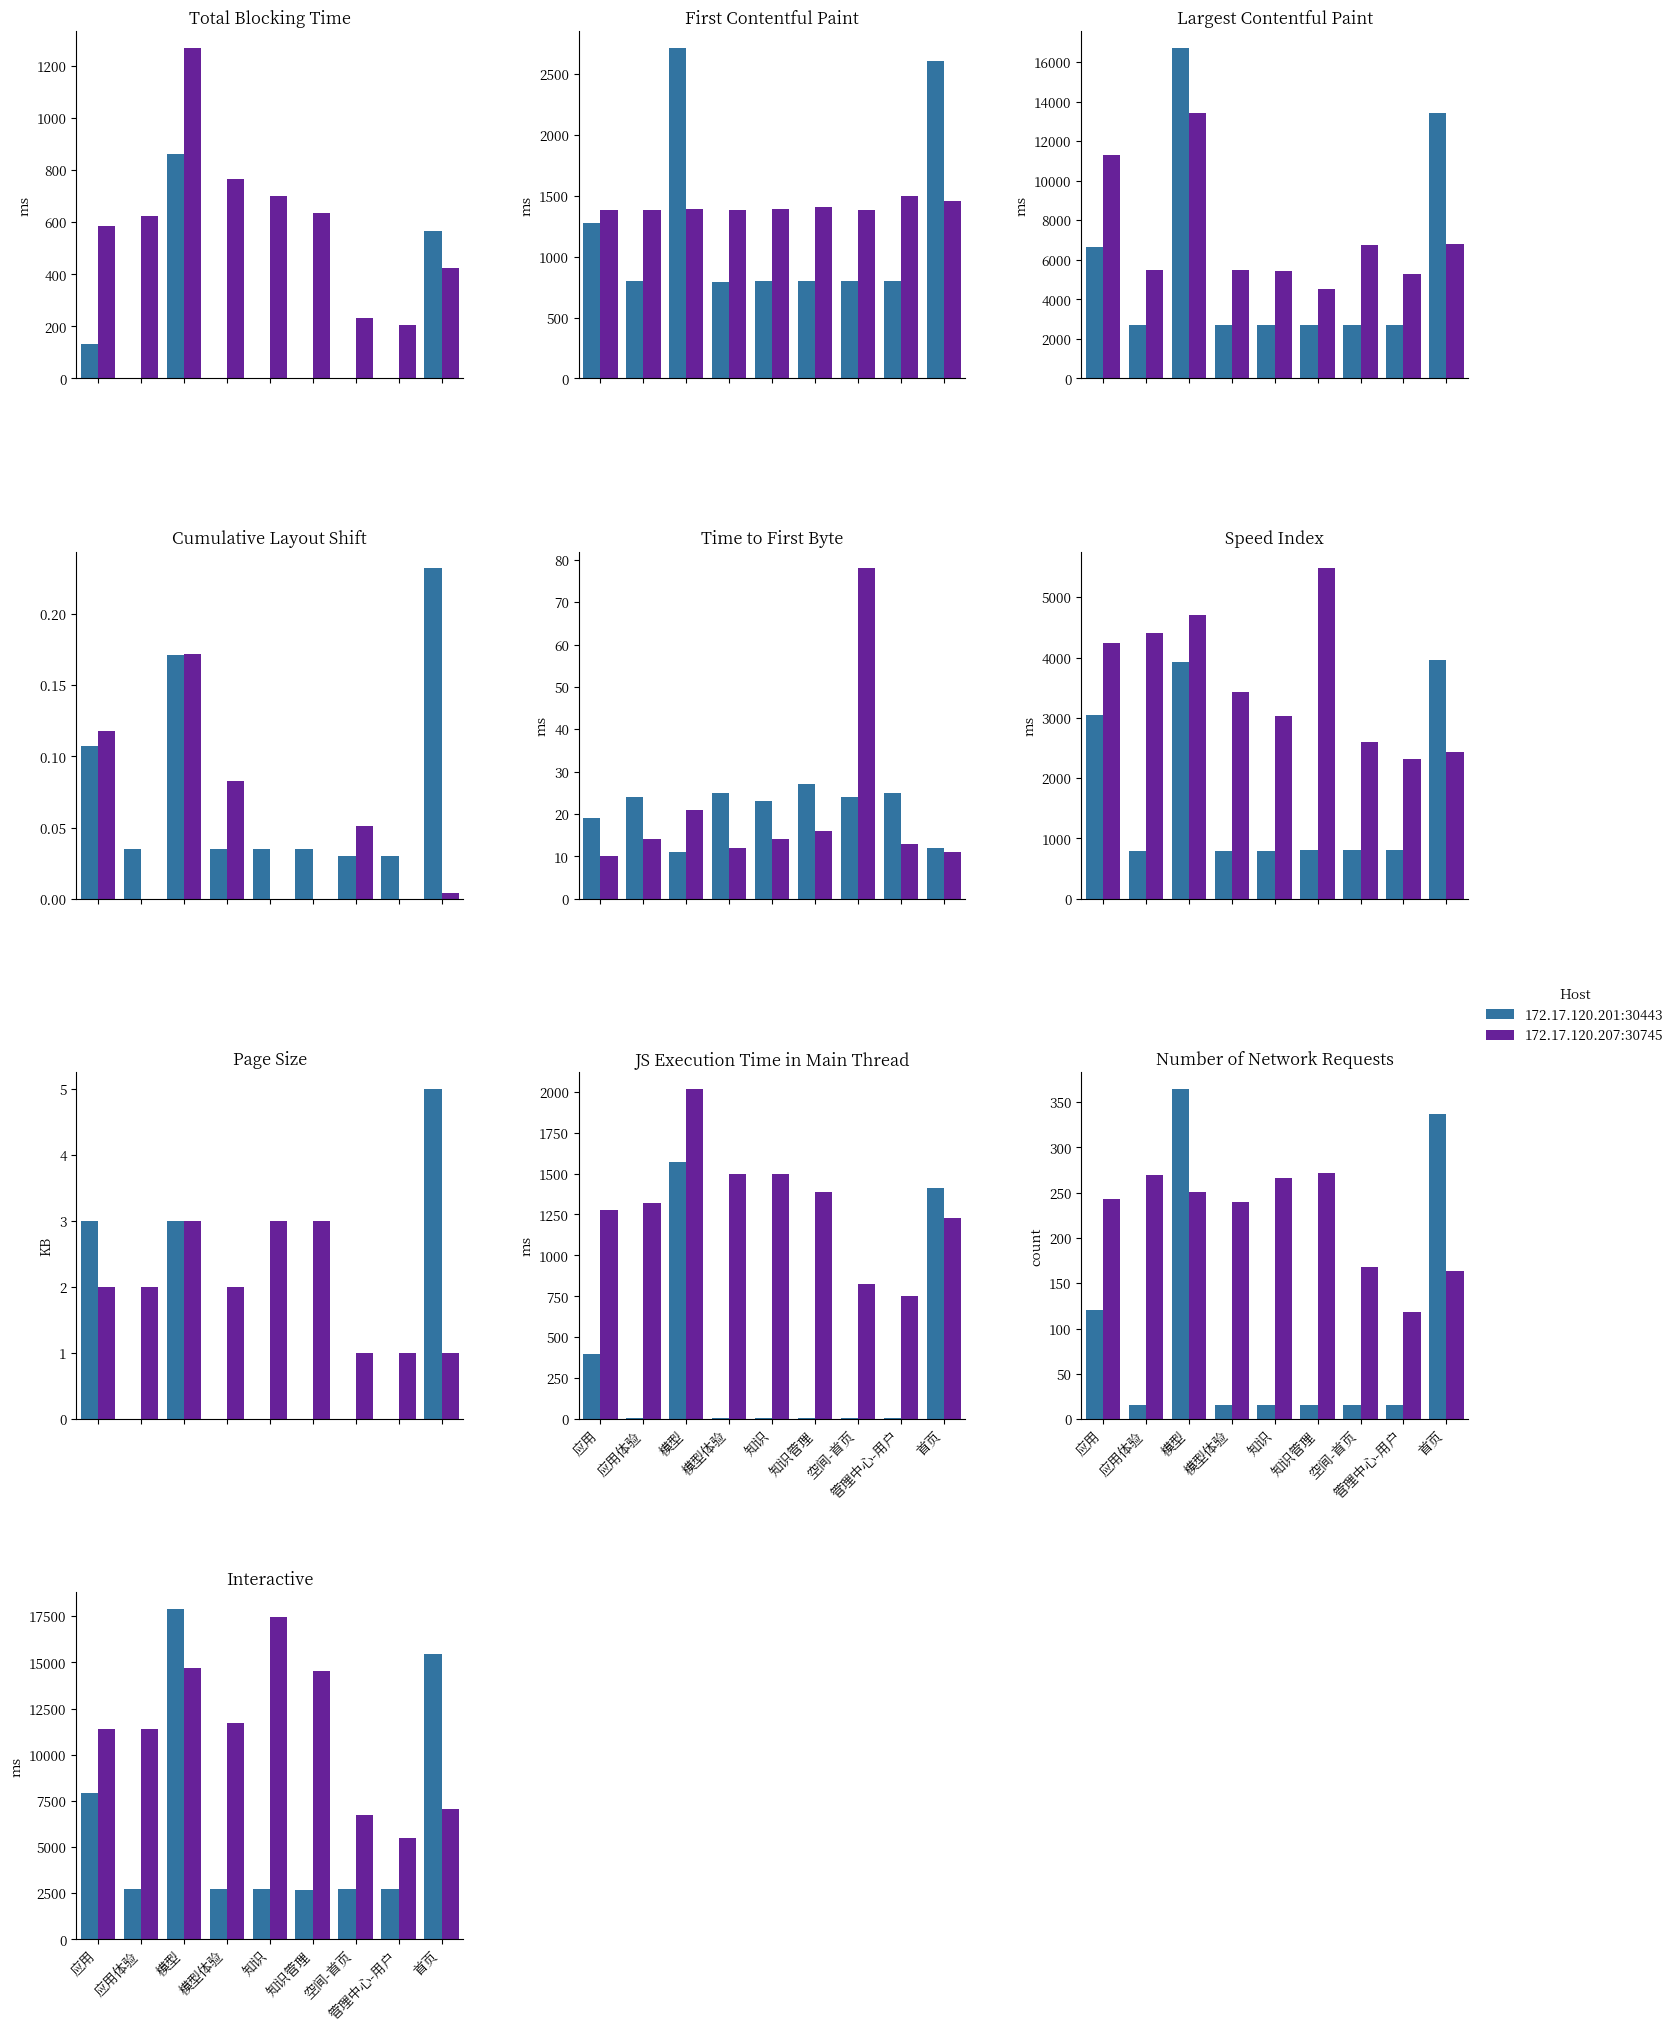

In [9]:
g = sns.FacetGrid(m_df, col='Metric', col_wrap=3, palette=c_palette, sharey=False, height=5)
g.map_dataframe(sns.barplot, x='pagename', y='Value', hue='host', dodge=True, palette=c_palette)

for ax, col_name in zip(g.axes.flat, m_df['Metric'].unique()):
    ax.set_xlabel("")
    ax.set_title(metric_chinese_mapping[col_name])
    ax.set_ylabel(metric_units[col_name])
    ax.set_xticks(range(len(m_df['pagename'].unique())))
    ax.set_xticklabels(m_df['pagename'].unique(), rotation=45, ha='right')
    for label in ax.get_xticklabels():
        label.set_visible(True)

g.figure.subplots_adjust(hspace=0.5, wspace=0.3)
g.add_legend(title='Host')
plt.savefig('grouped_barplots.png', dpi=300, bbox_inches='tight')
plt.show()